In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
dataset_path = '/content/CNN_dataset.zip'
unzip_dir = '/content/CNN_dataset'

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)


In [3]:
dataset_dir = '/content/CNN_dataset/CNN_dataset'

In [4]:
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        print(f"Category: {category}")
        print(f"Number of images in {category}: {len(os.listdir(category_path))}")

Category: ChestCT
Number of images in ChestCT: 10000
Category: Hand
Number of images in Hand: 10000
Category: CXR
Number of images in CXR: 10000
Category: HeadCT
Number of images in HeadCT: 10000
Category: AbdomenCT
Number of images in AbdomenCT: 10000


In [5]:
from glob import glob
import shutil

# Define paths
dataset_dir = '/content/CNN_dataset/CNN_dataset'
train_dir = '/content/dataset_split/train'
val_dir = '/content/dataset_split/val'
test_dir = '/content/dataset_split/test'

# Iterate over categories
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)

    # Collect image paths
    imgs = glob(os.path.join(category_path, '*.*'))  # Match all image files

    # Ensure images are found
    if len(imgs) == 0:
        print(f"No images found in {category}. Skipping...")
        continue

    print(f"Processing {category}: {len(imgs)} images")

    # Split into train, validation, and test sets
    train, temp = train_test_split(imgs, test_size=0.2, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    # Create directories
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

    # Copy files to respective directories
    for img in train:
        shutil.copy(img, os.path.join(train_dir, category))
    for img in val:
        shutil.copy(img, os.path.join(val_dir, category))
    for img in test:
        shutil.copy(img, os.path.join(test_dir, category))

Processing ChestCT: 10000 images
Processing Hand: 10000 images
Processing CXR: 10000 images
Processing HeadCT: 10000 images
Processing AbdomenCT: 10000 images
No images found in README.md. Skipping...
No images found in .DS_Store. Skipping...


In [6]:
for split in ['train', 'val', 'test']:
    split_dir = os.path.join('/content/dataset_split', split)
    print(f"{split} set:")
    for category in os.listdir(split_dir):
        category_path = os.path.join(split_dir, category)
        print(f"  {category}: {len(os.listdir(category_path))} images")

train set:
  ChestCT: 8000 images
  Hand: 8000 images
  CXR: 8000 images
  HeadCT: 8000 images
  AbdomenCT: 8000 images
val set:
  ChestCT: 1000 images
  Hand: 1000 images
  CXR: 1000 images
  HeadCT: 1000 images
  AbdomenCT: 1000 images
test set:
  ChestCT: 1000 images
  Hand: 1000 images
  CXR: 1000 images
  HeadCT: 1000 images
  AbdomenCT: 1000 images


In [7]:
train_dir = '/content/dataset_split/train'
val_dir = '/content/dataset_split/val'
test_dir = '/content/dataset_split/test'

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test sets do not need augmentation
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 40000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = Sequential([
    # Convolutional layers with batch normalization
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Global average pooling instead of Flatten
    GlobalAveragePooling2D(),

    # Fully connected layers
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(5, activation='softmax')  # 5 categories
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,453 (501.77 KB)

 Trainable params: 128,005 (500.02 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=20
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 491s 381ms/step - accuracy: 0.8758 - loss: 1.7573 - val_accuracy: 0.9448 - val_loss: 0.9025
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 474s 378ms/step - accuracy: 0.9856 - loss: 0.5361 - val_accuracy: 0.7884 - val_loss: 0.6677
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 475s 378ms/step - accuracy: 0.9918 - loss: 0.1895 - val_accuracy: 0.8694 - val_loss: 0.2998
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 473s 377ms/step - accuracy: 0.9941 - loss: 0.0819 - val_accuracy: 0.7112 - val_loss: 2.1888
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 502s 377ms/step - accuracy: 0.9956 - loss: 0.0464 - val_accuracy: 0.9994 - val_loss: 0.0481
Epoch 10/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - accuracy: 0.0000e+00 - loss: 0.

In [10]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")



157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9970 - loss: 0.0180
Test Accuracy: 0.99
Test Loss: 0.04


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


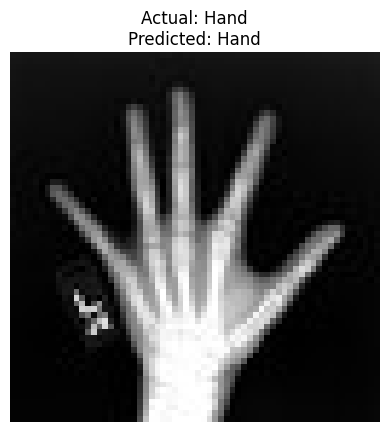

In [11]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Function to make predictions on a single image
def predict_image(model, img_path, class_indices):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Rescale
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Map class index to class label
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_label = class_labels[predicted_class]

    return predicted_label, prediction[0]

# Randomly pick an image from the test dataset
import random
test_sample_dir = random.choice([os.path.join(test_dir, category) for category in os.listdir(test_dir)])
test_sample_image = random.choice(os.listdir(test_sample_dir))
test_sample_path = os.path.join(test_sample_dir, test_sample_image)

# Predict
predicted_label, probabilities = predict_image(model, test_sample_path, test_generator.class_indices)

# Get the actual label from the file path (based on the directory structure)
actual_label = test_sample_dir.split('/')[-1]

# Display the image and predicted label
plt.imshow(load_img(test_sample_path))
plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
plt.axis('off')
plt.show()
